In [42]:
import numpy as np
import csv
from matplotlib import pyplot as plt
import random
%matplotlib inline
import os
from sklearn.cross_validation import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from sklearn.externals import joblib

In [9]:
path = os.getcwd()

In [5]:
## Loading data ##

# Load all training inputs to a python list
train_inputs = []
with open('E:\\MinMcGill\\ml\\project3\\data_and_scripts\\data_and_scripts\\train_inputs.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)  # skip the header
    for train_input in reader: 
        train_input_no_id = []
        for pixel in train_input[1:]: # Start at index 1 to skip the Id
            train_input_no_id.append(float(pixel))
        train_inputs.append(train_input_no_id) 

# Load all training ouputs to a python list
train_outputs = []
with open('E:\\MinMcGill\\ml\\project3\\data_and_scripts\\data_and_scripts\\train_outputs.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)  # skip the header
    for train_output in reader:  
        train_output_no_id = int(train_output[1])
        train_outputs.append(train_output_no_id)

In [6]:
## convert_to_numpy ##
# Convert python lists to numpy arrays
train_inputs_np = np.asarray(train_inputs)
train_outputs_np = np.asarray(train_outputs)

# Save as numpy array files
np.save('train_inputs', train_inputs_np)
np.save('train_outputs', train_outputs_np)

In [21]:
## Load numpy array files ##
train_inputs = np.load(path+'\\train_inputs.npy')
train_outputs = np.load(path+'\\train_outputs.npy')


In [7]:

pca = PCA(n_components = 821)
result = pca.fit(train_inputs)
VR = result.explained_variance_ratio_

joblib.dump(result, "PCA_821.pkl")
np.save('train_inputs_PCA', result.transform(train_inputs))
np.save('test_inputs_PCA', result.transform(train_outputs))

ValueError: operands could not be broadcast together with shapes (1,50000) (2304,) 

In [ ]:
train_inputs = np.load(path+'\\train_inputs_PCA.npy')
train_outputs = np.load(path+'\\train_outputs_PCA.npy')

In [31]:
## Define sigmoid function and its derivitive ##
def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1-sigmoid(x))

In [38]:
class NeuralNetwork:
    def __init__(self, num_input, num_hidden, num_output, sigmoid_func = 'sigmoid', iterations = 10000, learning_rate = .2):
        """
        :param num_input: The number of units in the input layer
        :param num_hidden: The number of units in the hidden layer
        :param num_output: The number of units in the output layer
        :param sigmoid_func: The activation function to be used. Can be "sigmoid" or "tanh"
        """
        
        # set the activation function to be used
        if sigmoid_func == 'sigmoid':
            self.sigmoid_func =  sigmoid
            self.sigmoid_func_deriv = sigmoid_deriv
        elif sigmoid_func == 'tanh':
            self.sigmoid_func = tanh
            self.sigmoid_func_deriv = tanh_deriv
            
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.iterations = iterations
        self.learning_rate =learning_rate
        
    ##set the weights of neurons in layers randomly from 0 to w, adding a bias unit at every layer
    def set_weight(self,w):
        self.weights = []
        # set the weights from the input layer to the hidden layer:[-w,w), add the weight of the bias term
        self.weights.append((2*np.random.random_sample((self.num_input + 1, self.num_hidden + 1))-1)*w)
        # set the weights from the hidden layer to the output layer:[-w,w), add the weight of the bias term
        self.weights.append((2*np.random.random((self.num_hidden + 1, self.num_output))-1)*w)
                
        
    def fitNN(self, X, Y):
        
        # adding the bias term to input data
        bias = np.ones(X.shape[0])
        X = np.concatenate((X, bias[:,np.newaxis]), axis=1)
        Y = np.array(Y)

        ## stochastic gradient descent
        for k in range(self.iterations):
            
            # pick a training example randomly
            index_ex = np.random.randint(X.shape[0],size=50)
            out = [X[index_ex]]

            ## forward pass            
            #compute the output of hidden units
            out.append(self.sigmoid_func(np.dot(out[0],  self.weights[0])))
            #compute the output of output units
            out.append(self.sigmoid_func(np.dot(out[1],  self.weights[1])))
            
            ## back propogation
            # for the output unit, compute the correction
            deltas = [(Y[index_ex] - out[-1]) * self.sigmoid_func_deriv(out[-1])]

            # for each hidden unit, compute its share of the correction
            deltas.append(deltas[-1].dot(self.weights[1].T)*self.sigmoid_func_deriv(out[1]))
            deltas.reverse()
            
            # update weights between the hidden layer and the output layer
            for i in range(len( self.weights)):
                 self.weights[i] += self.learning_rate * np.dot(np.matrix(out[i]).T,np.matrix(deltas[i]))/50
                
    def predict(self, x):
        # adding the bias term
        x = np.array(x)
        x = np.concatenate((x, [1]), axis=0)
        predictions = x
        # forward pass to get the classification of the input instance
        for i in range(0, len(self.weights)):
            predictions = self.sigmoid_func(np.dot(predictions, self.weights[i]))
        return predictions

In [34]:
## function of tuning parameter sets using kfold ##
def tune_para(X,y,param,k):                      
    KF = KFold(X_train.shape[0], n_folds=k)
    ave_precision = []
    for i in range (len(param)): 
        precision = []
    
        for train, test in KF:     
            train_x_kf, test_x_kf, train_y_kf, test_y_kf = X[train], X[test], y[train], y[test]
            labels_train_kf = LabelBinarizer().fit_transform(train_y_kf)

            nn = NeuralNetwork(param[i][0],param[i][1],param[i][2],param[i][3],param[i][4],param[i][5])    
            nn.set_weight(0.2)
            nn.fitNN(train_x_kf,labels_train_kf)
            
            predictions = []
            for j in range(test_x_kf.shape[0]):
                o = nn.predict(test_x_kf[j] )
                predictions.append(np.argmax(o))
            precision.append( np.mean(predictions == np.ravel(test_y_kf)))
        
        ave_precision.append( np.sum(precision) * 100 / k)
        print ('parameter set:', param[i], 'average precision: ',ave_precision[i], '%')
    
    best_param = param[np.argmax(ave_precision)]
    print ('The best parameter set until now:', best_param)
    return best_param

 


In [40]:
##
X = np.array(train_inputs)
y = np.array(train_outputs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, train_size = 0.2, random_state=0)
labels_train = LabelBinarizer().fit_transform(y_train)

#tune number of hidden units
print('Tune the number of hidden units')
param_set = [[2304,3000,10,'sigmoid',10000,.2],[2304,5000,10,'sigmoid',10000,.2],[2304,7000,10,'sigmoid',10000,.2]]
best_param_set = tune_para(X_train,y_train,param_set,5)
H = best_param_set[1]

#tune learning rate
print ('\n')
print ('Tune the learning rate of gradient descent')
param_set = [[2304,H,10,'sigmoid',10000,.15],[2304,H,10,'sigmoid',10000,.2],[2304,H,10,'sigmoid',10000,.25]]
best_param_set = tune_para(X_train,y_train,param_set,5)
L = best_param_set[5]

#tune number of iterations
print ('\n')
print ('Tune the number of iterations of gradient descent')
param_set = [[2304,H,10,'sigmoid',15000,L],[2304,H,10,'sigmoid',20000,L],[2304,H,10,'sigmoid',25000,L]]
best_param_set = tune_para(X_train,y_train,param_set,5)
I = best_param_set[4]

#tune activation function
print ('\n')
print ('Tune activatino function')
param_set = [[2304,H,10,'sigmoid',I,L],[2304,H,10,'tanh',I,L]]
best_param_set = tune_para(X_train,y_train,param_set,5)

print ('\n')
print ('The best parameters are:')
print('number of hidden units:', best_param_set[1])
print('learning rate:', best_param_set[5])
print('number of iterations:',best_param_set[4])
print('activatino function:',best_param_set[3])


Tune the number of hidden units
parameter set: [2304, 3000, 10, 'sigmoid', 10000, 0.2] average precision:  29.25 %
parameter set: [2304, 5000, 10, 'sigmoid', 10000, 0.2] average precision:  29.16 %
parameter set: [2304, 7000, 10, 'sigmoid', 10000, 0.2] average precision:  28.88 %
The best parameter set until now: [2304, 3000, 10, 'sigmoid', 10000, 0.2]


Tune the learning rate of gradient descent
parameter set: [2304, 3000, 10, 'sigmoid', 10000, 0.15] average precision:  29.29 %
parameter set: [2304, 3000, 10, 'sigmoid', 10000, 0.2] average precision:  28.87 %
parameter set: [2304, 3000, 10, 'sigmoid', 10000, 0.25] average precision:  28.3 %
The best parameter set until now: [2304, 3000, 10, 'sigmoid', 10000, 0.15]


Tune the number of iterations of gradient descent
parameter set: [2304, 3000, 10, 'sigmoid', 15000, 0.15] average precision:  28.7 %
parameter set: [2304, 3000, 10, 'sigmoid', 20000, 0.15] average precision:  27.79 %
parameter set: [2304, 3000, 10, 'sigmoid', 25000, 0.15] 

In [41]:
nn = NeuralNetwork(best_param_set[0],best_param_set[1],best_param_set[2],best_param_set[3],best_param_set[4],best_param_set[5])
nn.set_weight(0.2)
nn.fitNN(X_train,labels_train)

predictions = []
for i in range(X_test.shape[0]):
    o = nn.predict(X_test[i] )
    predictions.append(np.argmax(o))
print (confusion_matrix(y_test,predictions))
print (classification_report(y_test,predictions))

[[165   0  13  22   7   6  25  13   1  12]
 [  2 123  26  27  18  10  22  21  37   9]
 [ 36  26  37  27  29   7  22  26  15  14]
 [ 20  20  25  95   7  13  22   5  22   9]
 [ 12  14  17  14  71   7  30  39  14  32]
 [ 20   6  16  43  21  32  30  13  11  29]
 [ 28  10  11  10  18   9  67  32   8  20]
 [ 22  12  22  12  34  10  33  76   5  39]
 [  9  48  16  62  16  14  23   9  56  11]
 [ 18   7  13  17  32  11  35  44  18  56]]
             precision    recall  f1-score   support

          0       0.50      0.62      0.55       264
          1       0.46      0.42      0.44       295
          2       0.19      0.15      0.17       239
          3       0.29      0.40      0.34       238
          4       0.28      0.28      0.28       250
          5       0.27      0.14      0.19       221
          6       0.22      0.31      0.26       213
          7       0.27      0.29      0.28       265
          8       0.30      0.21      0.25       264
          9       0.24      0.22      

G:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


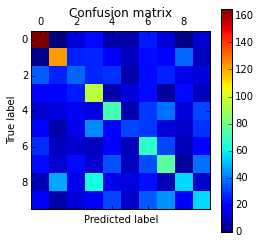

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()